In [123]:
import numpy as np
from icecream import ic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

## Kinetische Impulsbestimmung

Skalierungsfaktor $s_P$
\begin{align}
    s_P &= \frac{L_{1}}{30.01cm} - \frac{1}{30.01cm}\frac{L_{1} - L_{2}}{2} \\
    \Delta s_{P} &= \sqrt{ \left(\frac{\partial s_{P}}{\partial L_{1}} \Delta L_{1}\right)^{2} + 
                           \left(\frac{\partial s_{P}}{\partial L_{2}} \Delta L_{2}\right)^{2}}
\end{align}

Krümmungsradius $r_{real}$ in $cm$
\begin{align}
    r_{real} &= \frac{r_{gemessen}}{s_{P}} \\
    \Delta r_{real} &= \sqrt{ \left( \frac{\partial r_{real}}{\partial r_{gem}} \Delta r_{gem} \right)^2 + \left( \frac{\partial r_{real}}{\partial s_{P}} \Delta s_{P} \right)^2 } \\
                    &= \sqrt{\left(\frac{\Delta r_{gem}}{s_{P}}\right)^2 + \left( \frac{r_{gem}}{s_{P}^2} \Delta s_{P} \right)^2}
\end{align}

Impuls $p$ in $\frac{MeV}{c}$
\begin{align}
    p & = 2.998 \cdot B[T] \cdot r_{real}[cm] \frac{MeV}{c\cdot cm \cdot T} \\
    \Delta p &= \sqrt{ \left( \frac{\partial p}{\partial r_{real}} \Delta r_{real} \right)^2 } \\
             &= \sqrt{2.998 \cdot 2.05 \cdot \Delta r_{real}}
\end{align}

In [125]:
# Positionen, Einheit in cm
l1 = 45.5 
delta_l1 = 0.1
l2 = 59
delta_l2 = 0.1

# Skalierungsfaktor s_p
s_p = l1 - (l1 - l2)/2
s_p = s_p/30.01

ic(s_p)

# Fehler Skalierungsfaktor
delta_s_p_inner_term = (delta_l1 / (2*30.01))**2 + (delta_l2 / (2*30.01))**2
delta_s_p = np.sqrt(delta_s_p_inner_term)
ic(delta_s_p)

# Krümmungsradius
def r_real(r_gem): 
    return r_gem / s_p # Krümmungsradius r_real in cm

# Fehler Krümmungsradius
def delta_r_real(r_gem, delta_r_gem):
    delta_r_real_inner_term = (delta_r_gem / s_p)**2 + ( (r_gem / s_p**2) * delta_s_p)**2
    delta_r_real_complete_term = np.sqrt(delta_r_real_inner_term)
    return delta_r_real_complete_term

# Impuls, kinetischer Ausdruck in MeV/c
B = 2.05 # Magnetische Flussstärke in T
def momentum(r_real):
    return 2.998 * B * r_real


# Fehler Impuls, kinetischer Ausdruck
def delta_momentum(r_real, delta_r_real):
    error_r = 2.998 * B * delta_r_real
    error_theta = momentum(r_real)*np.deg2rad(20)
    return np.sqrt( error_r**2 + error_theta**2 )

def bubble_real(bubble_measured):
    return (bubble_measured * s_p) / 4

# Alles in einem
dfs = [] # Gesamtdataframe für alle Topologien
def parameterset(r_gem, delta_r_gem, charge, bubble, delta_bubble, angle):
    
    # ic(r_real(r_gem))
    # ic(delta_r_real(r_gem, delta_r_gem))
    # ic(momentum(r_real(r_gem)))
    # ic(delta_momentum(delta_r_real(r_gem, delta_r_gem)))

    # Array
    r_gem_array = np.atleast_1d(r_gem)  
    delta_r_gem_array = np.atleast_1d(delta_r_gem)  

    # Tabellierung
    # Um nur die Tabelle aufzurufen, gebe ein: parameterset(r_gem, delta_r_gem)[4]
    r_real_values = r_real(r_gem_array)
    delta_r_real_values = delta_r_real(r_gem_array, delta_r_gem_array)
    momentum_values = momentum(r_real_values)
    delta_momentum_values = delta_momentum(r_real_values, delta_r_real_values)
    
    df = pd.DataFrame({
        "charge": charge,
        "r_gem": r_gem_array,
        "delta_r_gem": delta_r_gem_array,
        "r_real": r_real_values,
        "delta_r_real": delta_r_real_values,
        "angle": angle,
        "delta_angle": np.float64(10),
        "momentum": momentum_values,
        "delta_momentum": delta_momentum_values,
        "rho" : bubble,
        "delta_rho": delta_bubble
    }, index=np.arange(1, len(r_gem_array) + 1))

    dfs.append(df)
    
    return r_real(r_gem), delta_r_real(r_gem, delta_r_gem), momentum(r_real(r_gem)), delta_momentum(r_real(r_gem), delta_r_real(r_gem, delta_r_gem)), df

ic| s_p: 1.7410863045651448
ic| delta_s_p: 0.0023562371915579724


## Bläschendichte und die Bethe-Bloch Formel
Bläschendichte $\rho_{Bl}$ wird abgelesen und mit Vergrößerungsfaktor skaliert. Daher gibt es zwei Fehler: Fehler des Vergrößerungsfaktors und Fehler aus dem Ablesen
\begin{align}
    \Delta \rho_{Bl,gem} &= \Delta \rho_{sys} + \Delta \rho_{stat} \\
    \rho_{Bl} &= \frac{\rho_{Bl, gem}}{4}\cdot s_P \\
    \Delta \rho_{Bl} &= \sqrt{ \left( \frac{s_P}{4}\Delta \rho_{Bl, gem} \right)^2 + \left( \frac{\rho_{Bl, gem}}{4} \Delta s_P \right)^2} 
\end{align}
Daraus folgt für den Kalibrationsfaktor (Wir gehen davon aus, dass es keine Ungenauigkeit bei der Angabe des Eingangsimpulses $p_{K^+}=810\frac{MeV}{c}$ gibt)
\begin{align}
    \rho_{Bl} &= C \cdot \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right) \\
    C &= \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right)^{-1}\rho_{Bl} \\
    \Delta C &= \sqrt{ \left( \frac{\partial C}{\partial \rho_{Bl}} \Delta \rho_{Bl} \right)^2 } \\
                     &= \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right)^{-1} \Delta \rho_{Bl}
\end{align}

ic| rho_kaon: 22.634121959346885
ic| delta_rho_kaon: 4.444708251089532
ic| beta_kaon: 0.8538910201152645
ic| calibration_value: 1.4980548202402983
ic| delta_calibration_value: 0.294176051187922


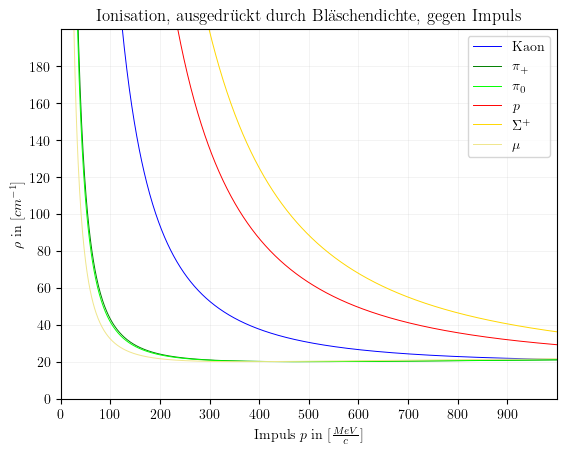

In [126]:
# def delta_rho(rho_measured,delta_rho_measured_systematic):
#     delta_rho_measured_statistical = np.sqrt(rho_measured)
#     delta_rho_measured = delta_rho_measured_systematic + delta_rho_measured_statistical
#     delta_rho = np.sqrt( (delta_rho_measured / s_p)**2 + (rho_measured * delta_s_p / s_p**2)**2 )
#     return delta_rho

def delta_rho(rho_measured,delta_rho_measured_systematic):
    
    delta_rho_measured_statistical = np.sqrt(rho_measured)
    delta_rho_measured = delta_rho_measured_systematic + delta_rho_measured_statistical

    delta_rho = np.sqrt( (delta_rho_measured * s_p / 4)**2 + (rho_measured * delta_s_p / 4)**2 )
    return delta_rho

rho_kaon_measured = 52 # (49, 55) 
delta_rho_kaon_measured_systematic = 3

rho_kaon = rho_kaon_measured / (4/s_p) # per 4 cm -> per cm; länge mit vergrößerungsfaktor skaliert
delta_rho_kaon = delta_rho(rho_kaon_measured, delta_rho_kaon_measured_systematic)

ic(rho_kaon)
ic(delta_rho_kaon)

momentum_kaon = 810 # in MeV/c
mass_kaon = 493.7 # in MeV/c^2 , same value for rest energy

# some more values
mass_pion_charged = 139.57 # in MeV/c
mass_pion_zero = 135
mass_proton = 938.27
mass_sigma_plus = 1189 
mass_muon = 105.7 # same for both plus and minus  

# beta_kaon = np.sqrt( 1 - ( mass_kaon / (mass_kaon + momentum_kaon) )**2)
beta_kaon = momentum_kaon/np.sqrt(mass_kaon**2 + momentum_kaon**2)
ic(beta_kaon)

# calibrated terms inside the bracket of the bethe bloch formula
cal_bethebloch_log = np.log( (46880 * beta_kaon**2) / (1 - beta_kaon**2) )
cal_bethebloch_logbybeta = cal_bethebloch_log / beta_kaon**2
cal_bethebloch_bracket = cal_bethebloch_logbybeta - 1

calibration_value = rho_kaon / cal_bethebloch_bracket
ic(calibration_value)

# error of calibration value
delta_calibration_value = cal_bethebloch_bracket**(-1) * delta_rho_kaon
ic(delta_calibration_value)

def bubbledensity(calibrationfactor, mass, momentum):
    with np.errstate(divide='ignore', invalid='ignore'):
        # beta = np.sqrt( 1 - ( mass / (mass + momentum) )**2)
        beta = momentum/np.sqrt(mass**2 + momentum**2)
        beta = np.where(beta < 1e-2, 1e-2, beta)  # otherwise, numerical artifacts at p > 6   
        bethebloch_log = np.log( (46880 * beta**2) / (1 - beta**2) )
        bethebloch_logbybeta = bethebloch_log / beta**2
        bethebloch_bracket = bethebloch_logbybeta - 1
        
        return calibrationfactor * bethebloch_bracket 


p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots()
ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

ax.set_title('Ionisation, ausgedrückt durch Bläschendichte, gegen Impuls')
ax.set_ylim([0, 200]) 
ax.set_xlim([0,1000])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(0, 1000, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(0, 200, 20)) 
ax.legend()
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Eichkurven.pdf")
plt.show()

## Versuche/Topologien

In [127]:
# Maßstabsetzung, Impuls = 810MeV/c
r_gem1 = 230 # gemessener Krümmungsradius in cm
delta_r_gem1 = 7.5

df1 = parameterset(r_gem1, delta_r_gem1, "-", rho_kaon, delta_rho_kaon, 0)[4]
df1

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,230,7.5,132.101435,4.311364,0,10.0,811.882212,284.63637,22.634122,4.444708


## Versuch 2, Folie 223

In [128]:
# Folie 223
r_gem1 = 65
delta_r_gem1 = 2.5
theta_1 = -25 # possibly 360 - 25 = 335 
charge_1 = "-"
bubble_1 = "NaN"
delta_bubble_1 = "NaN"
angle_1 = 25

r_gem2 = 80 
delta_r_gem2 = 2.5
theta_2 = 9
charge_2 = "+"
bubble_2 = "NaN"
delta_bubble_2 = "NaN"
angle_2 = 9

r_gem3 = 90
delta_r_gem3 = 2.5
theta_3 = 14
charge_3 = "-"
bubble_3 = "NaN"
delta_bubble_3 = "NaN"
angle_3 = 14

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2,r_gem3])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,])
charge = [charge_1, charge_2, charge_3]
bubble = [bubble_1, bubble_2, bubble_3]
delta_bubble = [delta_bubble_1, delta_bubble_2, delta_bubble_3]
angle = [angle_1, angle_2, angle_3]

df2 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df2

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,65,2.5,37.333014,1.436774,25,10.0,229.444973,80.576713,NaN,NaN
2,+,80,2.5,45.948325,1.437231,9,10.0,282.393813,98.969005,NaN,NaN
3,-,90,2.5,51.691866,1.437588,14,10.0,317.693039,111.247196,NaN,NaN


## Versuch 3, Folie 229, Topologie 201

In [129]:
r_gem1 = 140
delta_r_gem1 = 5

bubble_1_measured = 47.5 # 47 and 48
delta_bubble_1_measured_systematic = 0.5

bubble_1 = bubble_real(bubble_1_measured)
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "-"
angle_1 = -25



r_gem2 = 36
delta_r_gem2 = 2.5

bubble_2_measured = 53 # 50 and 56
delta_bubble_2_measured_systematic = 3
bubble_2 = bubble_real(bubble_2_measured)
delta_bubble_2 = delta_rho(bubble_2_measured, delta_bubble_2_measured_systematic)
charge_2 = "-"
angle_2 = -22

r_gem3 = 42.5
delta_r_gem3 = 2.5
bubble_3_measured = 52.5 # 46 and 59
delta_bubble_3_measured_systematic = 6.5
bubble_3 = bubble_real(bubble_3_measured)
delta_bubble_3 = delta_rho(bubble_3_measured, delta_bubble_3_measured_systematic)
charge_3 = "+"
angle_3 = 42

r_gem4 = 33
delta_r_gem4 = 2.5
bubble_4_measured = 59.5 # 58 and 61
delta_bubble_4_measured_systematic = 1.5
bubble_4 = bubble_real(bubble_4_measured)
delta_bubble_4 = delta_rho(bubble_4_measured, delta_bubble_4_measured_systematic)
charge_4 = "+"
angle_4 = 57

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2,r_gem3,r_gem4])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,delta_r_gem4])
charge = [charge_1, charge_2, charge_3, charge_4]
bubble = np.array([bubble_1, bubble_2, bubble_3, bubble_4])
delta_bubble = np.array([delta_bubble_1, delta_bubble_2, delta_bubble_3, delta_bubble_4])
angle = np.array([angle_1, angle_2, angle_3, angle_4])

df3 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df3

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,140.0,5.0,80.409569,2.873831,-25,10.0,494.189172,173.406403,20.675400,3.217660
2,-,36.0,2.5,20.676746,1.436158,-22,10.0,127.077216,45.227945,23.069394,4.474749
3,+,42.5,2.5,24.410048,1.436265,42,10.0,150.021713,53.106205,22.851758,5.983187
4,+,33.0,2.5,18.953684,1.436114,57,10.0,116.487448,41.608692,25.898659,4.010582


## Versuch 4, Folie 239, Topologie 200

In [130]:
r_gem1 = 113
delta_r_gem1 = 5
bubble_1_measured = 53 # 52 and 54
delta_bubble_1_measured_systematic = 1
bubble_1 = bubble_real(bubble_1_measured)
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "+"
angle_1 = -30.5

r_gem2 = 215
delta_r_gem2 = 7.5
bubble_2 = np.array([49,51])
bubble_2_measured = 50 # 49 and 51
delta_bubble_2_measured_systematic = 1
bubble_2 = bubble_real(bubble_2_measured)
delta_bubble_2 = delta_rho(bubble_2_measured, delta_bubble_2_measured_systematic)
charge_2 = "-"
angle_2 = 56

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2])
charge = [charge_1, charge_2]
bubble = np.array([bubble_1, bubble_2])
delta_bubble = np.array([delta_bubble_1, delta_bubble_1])
angle = np.array([angle_1, angle_2])

df4 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df4 

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,+,113,5.0,64.902010,2.873113,-30.5,10.0,398.881261,140.351044,23.069394,3.604232
2,-,215,7.5,123.486124,4.310896,56.0,10.0,758.933372,266.239272,21.763579,3.604232


## Versuch 5, Folie 285, Topologie 100

In [131]:
r_gem1 = 54
delta_r_gem1 = 2.5
bubble_1_measured = 49 # 48 and 50
delta_bubble_1_measured_systematic = 1
bubble_1 = bubble_real(bubble_1_measured)
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "-"
angle_1 = -58

# ----------------------------------------------------------------

r_gem = np.array([r_gem1])
delta_r_gem = np.array([delta_r_gem1])
charge = [charge_1]
bubble = np.array([bubble_1])
delta_bubble = np.array([delta_bubble_1])
angle = np.array([angle_1])


df5 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df5

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,54,2.5,31.01512,1.436499,-58,10.0,190.615824,67.120632,21.328307,3.482292


## Gesamttabelle

In [132]:
# Gesamtdataframe dfs

k=0
firstindex = []
secondindex = []
for df in dfs:
    indexlength = len(df.index)
    # firstindexentry = (np.ones(indexlength) + k).tolist() 
    firstindexentry = (np.ones(indexlength) + k).astype(int).tolist()
    firstindex.extend(firstindexentry) 
    j=0
    for j in range(1, indexlength + 1):
        secondindex.append(j)
    k += 1


total_df = pd.concat(dfs, axis=0)
total_df.index = pd.MultiIndex.from_arrays([firstindex, secondindex], names=["Versuch", "Teilchenspur"])

total_df.loc[(1,1),'delta_angle'] = np.float64(0) # no uncertainty on the first value
total_df

charge  r_gem  delta_r_gem      r_real  delta_r_real  \
Versuch Teilchenspur                                                        
1       1                 -  230.0          7.5  132.101435      4.311364   
2       1                 -   65.0          2.5   37.333014      1.436774   
        2                 +   80.0          2.5   45.948325      1.437231   
        3                 -   90.0          2.5   51.691866      1.437588   
3       1                 -  140.0          5.0   80.409569      2.873831   
        2                 -   36.0          2.5   20.676746      1.436158   
        3                 +   42.5          2.5   24.410048      1.436265   
        4                 +   33.0          2.5   18.953684      1.436114   
4       1                 +  113.0          5.0   64.902010      2.873113   
        2                 -  215.0          7.5  123.486124      4.310896   
5       1                 -   54.0          2.5   31.015120      1.436499   

                      angle  delta_angle    momentum  delta_momentum  \
Versuch Teilchenspur                                                   
1       1               0.0          0.0  811.882212      284.636370   
2       1              25.0         10.0  229.444973       80.576713   
        2               9.0         10.0  282.393813       98.969005   
        3              14.0         10.0  317.693039      111.247196   
3       1             -25.0         10.0  494.189172      173.406403   
        2             -22.0         10.0  127.077216       45.227945   
        3              42.0         10.0  150.021713       53.106205   
        4              57.0         10.0  116.487448       41.608692   
4       1             -30.5         10.0  398.881261      140.351044   
        2              56.0         10.0  758.933372      266.239272   
5       1             -58.0         10.0  190.615824       67.120632   

                            rho delta_rho  
Versuch Teilchenspur                       
1       1             22.634122  4.444708  
2       1                   NaN       NaN  
        2                   NaN       NaN  
        3                   NaN       NaN  
3       1               20.6754   3.21766  
        2             23.069394  4.474749  
        3             22.851758  5.983187  
        4             25.898659  4.010582  
4       1             23.069394  3.604232  
        2             21.763579  3.604232  
5       1             21.328307  3.482292

## Impulserhaltung

In [133]:
# Impulsberechnung
momentumcols = ['momentum', 'delta_momentum', 'angle', 'delta_angle']
momentum_df = [(index, total_df.loc[index, momentumcols].values.tolist()) for index in total_df.index]
# ic(momentum_df)

# momentum_x_list = [values for _, values in momentum_df]
# ic(momentum_x_list)
# delta_momentum_x = np.sqrt( (np.cos(np.def2rad(angle))*delta_momentum)**2 + (momentum * np.sin(np.deg2rad(angle)) * delta_angle)**2) 
momentum_x_list = [[index, momentum * np.cos(np.deg2rad(angle)), 
                    np.sqrt( 
                        (np.cos(np.deg2rad(angle))*delta_momentum)**2 
                      + (momentum * np.sin(np.deg2rad(angle)) * np.deg2rad(delta_angle))**2
                           ) ] 
                   for index, [momentum, delta_momentum, angle, delta_angle] in momentum_df]
momentum_x_df = pd.DataFrame([(index, value, error) for index, value, error in momentum_x_list], 
                  columns=["Index", "Value", "Error"])
momentum_x_df.set_index(pd.MultiIndex.from_tuples(momentum_x_df["Index"]), inplace=True)
momentum_x_df.drop(columns=["Index"], inplace=True)
momentum_x_df = momentum_x_df.groupby(level=[0, 1]).sum()
# ic(momentum_x_df)
momentum_x_total_df = momentum_x_df.groupby(level=0).sum()
momentum_x_total_df ["Error"] = np.sqrt(momentum_x_df.groupby(level=0)["Error"].apply(lambda x: np.sum(x**2)))
# ic(momentum_x_total_df)


momentum_y_list = [[index, momentum * np.sin(np.deg2rad(angle)),
                    np.sqrt( 
                        (np.sin(np.deg2rad(angle))*delta_momentum)**2 
                      + (momentum * np.cos(np.deg2rad(angle)) * np.deg2rad(delta_angle))**2
                           ) ] 
                   for index, [momentum, delta_momentum, angle, delta_angle] in momentum_df]
momentum_y_df = pd.DataFrame([(index, value, error) for index, value, error in momentum_y_list], 
                  columns=["Index", "Value", "Error"])
momentum_y_df.set_index(pd.MultiIndex.from_tuples(momentum_y_df["Index"]), inplace=True)
momentum_y_df.drop(columns=["Index"], inplace=True)
momentum_y_df = momentum_y_df.groupby(level=[0, 1]).sum()
# ic(momentum_y_df)
momentum_y_total_df = momentum_y_df.groupby(level=0).sum()
momentum_y_total_df["Error"] = np.sqrt(momentum_y_df.groupby(level=0)["Error"].apply(lambda x: np.sum(x**2)))
# ic(momentum_y_total_df)

In [134]:
momentum_x_total_df

,Value,Error
1,811.882212,284.636370
2,795.121040,164.516208
3,740.642909,174.711736
4,768.077882,223.822787
5,101.010997,45.399563


In [135]:
momentum_y_total_df

,Value,Error
1,0.000000,0.000000
2,218.000663,93.301469
3,-58.378618,123.178786
4,426.736738,250.753124
5,-161.651386,59.589159


Versuch 2: \
unerwarteter y-Komponentenimpuls 218 bleibt übrig, Impulserhaltung wird nicht bestätigt. \
Versuch 3: \
keine neutralen Teilchen zu erwarten, Impulserhaltung bestätigt. \
Versuch 4: \
y-Komponentenimpuls von 426.74 bleibt übrig, höchstwahrscheinlich von einem neutralen Teilchen. 
Versuch 5: \
Impuls vom neutralen pion bleibt wie erwartet übrig.

## Energieerhaltung

In [136]:
# momentum_kaon = 810 # in MeV/c
# mass_kaon = 493.7 # in MeV/c^2 , same value for rest energy

# # some more values
# mass_pion_charged = 139.57 # in MeV/c
# mass_pion_zero = 135
# mass_proton = 938.27
# mass_sigma_plus = 1189 
# mass_muon = 105.7 # same for both plus and minus  

# total_df

In [137]:
# Energieerhaltung
def energy(momentum, mass):
    return np.sqrt(momentum**2 + mass**2)

def delta_energy(momentum, delta_momentum, mass):
    rootterm = (momentum**2 + mass**2)**(-1/2)
    return rootterm * momentum * delta_momentum

kaon_energy = energy(total_df['momentum'], mass_kaon)
delta_kaon_energy = delta_energy(total_df['momentum'], total_df['delta_momentum'], mass_kaon)
pion_energy = energy(total_df['momentum'], mass_pion_charged)
delta_pion_energy = delta_energy(total_df['momentum'], total_df['delta_momentum'], mass_pion_charged)
proton_energy = energy(total_df['momentum'], mass_proton)
delta_proton_energy = delta_energy(total_df['momentum'], total_df['delta_momentum'], mass_proton)

# Energiewertetablle
energy_df = pd.DataFrame({
        "charge": total_df['charge'],
        "E_kaon": kaon_energy,
        "delta_E_kaon" : delta_kaon_energy,
        "E_pion_charged": pion_energy,
        "delta_E_pion_charged" : delta_pion_energy,
        "E_proton": proton_energy,
        "delta_E_proton": delta_proton_energy
    }, index=pd.MultiIndex.from_arrays([firstindex, secondindex], names=["Versuch", "Teilchenspur"]))


# linke Seite
energy_lhd = energy(momentum_kaon, mass_kaon) + energy(0,mass_proton)
ic(energy_lhd)
# rechte Seite

# Versuch 2, Kontrolle
energy_df.loc[energy_df['charge'] == '+', ['E_kaon', 'delta_E_kaon']] = np.nan
energy_df.loc[energy_df['charge'] == '-', ['E_proton', 'delta_E_proton']] = np.nan
energy_df

ic| energy_lhd: 1886.86880349914


charge      E_kaon  delta_E_kaon  E_pion_charged  \
Versuch Teilchenspur                                                    
1       1                 -  950.206512    243.201033      823.791546   
2       1                 -  544.412239     33.959416      268.560571   
        2                 +         NaN           NaN      315.001667   
        3                 -  587.084796     60.199923      346.999499   
3       1                 -  698.543219    122.677545      513.519934   
        2                 -  509.792417     11.274082      188.754877   
        3                 +         NaN           NaN      204.905586   
        4                 +         NaN           NaN      181.794143   
4       1                 +         NaN           NaN      422.594421   
        2                 -  905.383650    223.173754      771.660319   
5       1                 -  529.220259     24.175671      236.250243   

                      delta_E_pion_charged     E_proton  delta_E_proton  
Versuch Teilchenspur                                                     
1       1                       280.521458          NaN             NaN  
2       1                        68.840790          NaN             NaN  
        2                        88.724085   979.845324       28.523109  
        3                       101.851616          NaN             NaN  
3       1                       166.878754          NaN             NaN  
        2                        30.449234          NaN             NaN  
        3                        38.881731   950.187933        8.384745  
        4                        26.661422   945.473383        5.126416  
4       1                       132.475486  1019.537568       54.910582  
        2                       261.848203          NaN             NaN  
5       1                        54.155519          NaN             NaN

In [138]:
# Beim Versuch 2 wissen wir, das alle Ausgangsteilchen Pionen sind
totalenergy_ex2 = energy_df.loc[2,'E_pion_charged'].sum()
delta_totalenergy_ex2 = np.sqrt((energy_df.loc[2, 'delta_E_pion_charged'] ** 2).sum())
print("Gesamtenergie der Eingangsteilchen, Versuch 2:")
print(energy(momentum_kaon, mass_kaon))
print("\n")
print("Gesamtenergie der Ausgangsteilchen, Versuch 2:   ", totalenergy_ex2, f'±', delta_totalenergy_ex2)

Gesamtenergie der Eingangsteilchen, Versuch 2:
948.59880349914


Gesamtenergie der Ausgangsteilchen, Versuch 2:    930.5617375520868 ± 151.60728608280186


In [139]:
# Versuch 3
'''
hypothese a) Spur 1 pion, Spur 4 proton
             Spur 2 pion, Spur 3 pion
hypothese b) Spur 1 pion, Spur 4 pion
             Spur 2 pion, Spur 3 proton
'''

totalenergy_ex3_a = energy_df.loc[(3,1),'E_pion_charged'] + \
                    energy_df.loc[(3,4),'E_proton'] + \
                    energy_df.loc[(3,2),'E_pion_charged'] + \
                    energy_df.loc[(3,3),'E_pion_charged']
delta_totalenergy_ex3_a = np.sqrt( energy_df.loc[(3,1),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(3,4),'delta_E_proton']**2 + \
                                   energy_df.loc[(3,2),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(3,3),'delta_E_pion_charged']**2 )

totalenergy_ex3_b = energy_df.loc[(3,1),'E_pion_charged'] + \
                    energy_df.loc[(3,4),'E_pion_charged'] + \
                    energy_df.loc[(3,2),'E_pion_charged'] + \
                    energy_df.loc[(3,3),'E_proton']
delta_totalenergy_ex3_b = np.sqrt( energy_df.loc[(3,1),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(3,4),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(3,2),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(3,3),'delta_E_proton']**2 )
print("Gesamtenergie der Eingangsteilchen, Versuch 3:")
print(energy(momentum_kaon, mass_kaon) + energy(0,mass_proton))
print("\n")
print("Gesamtenergie der Ausgangsteilchen, Versuch 3:")
print("Hypothese a)   ",totalenergy_ex3_a, f'±', delta_totalenergy_ex3_a)
print("Hypothese b)   ",totalenergy_ex3_b, f'±', delta_totalenergy_ex3_b)

Gesamtenergie der Eingangsteilchen, Versuch 3:
1886.86880349914


Gesamtenergie der Ausgangsteilchen, Versuch 3:
Hypothese a)    1852.653781144466 ± 174.10842456458622
Hypothese b)    1834.2568871490726 ± 171.92094040992868


In [140]:
# Versuch 4
'''
hypothese a) Spur 1 Proton, Spur 2 Kaon, aber unwahrscheinlich, da ein signifikanter y-Komponentenimpuls fehlt -> indiz für neutrales Teilchen
hypothese b) Spur 1 proton, Spur 2 Kaon, 
             Teilchen 3 neutrales pion
hypothese c) Spur 1 pion, Spur 2 Kaon,
             Teilchen 3 Neutron
hypothese d) Spur 1 proton, Spur 2 pion,
             Teilchen 3 neutrales Kaon zu zwei pionen
hypothese e) Spur 1 pion, Spur 2 pion
             Teilchen 3 neutrales lambda zu neutron und neutralem pion
'''
totalenergy_ex4_a = energy_df.loc[(4,1),'E_proton'] + \
                    energy_df.loc[(4,2),'E_kaon']
delta_totalenergy_ex4_a = np.sqrt( energy_df.loc[(4,1),'delta_E_proton']**2 + \
                                   energy_df.loc[(4,2),'delta_E_kaon']**2 )

totalenergy_ex4_c = energy_df.loc[(4,1),'E_pion_charged'] + \
                    energy_df.loc[(4,2),'E_kaon']
delta_totalenergy_ex4_c = np.sqrt( energy_df.loc[(4,1),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(4,2),'delta_E_kaon']**2 )

totalenergy_ex4_d = energy_df.loc[(4,1),'E_proton'] + \
                    energy_df.loc[(4,2),'E_pion_charged']
delta_totalenergy_ex4_d = np.sqrt( energy_df.loc[(4,1),'delta_E_proton']**2 + \
                                   energy_df.loc[(4,2),'delta_E_pion_charged']**2 )

totalenergy_ex4_e = energy_df.loc[(4,1),'E_pion_charged'] + \
                    energy_df.loc[(4,2),'E_pion_charged']
delta_totalenergy_ex4_e = np.sqrt( energy_df.loc[(4,1),'delta_E_pion_charged']**2 + \
                                   energy_df.loc[(4,2),'delta_E_pion_charged']**2 )


print("Gesamtenergie der Eingangsteilchen, Versuch 4:")
print(energy(momentum_kaon, mass_kaon) + energy(0,mass_proton))
print("\n")
print("Gesamtenergie der Ausgangsteilchen, Versuch 4:")
print("Hypothese a) und b)    ",totalenergy_ex4_a, f'±', delta_totalenergy_ex4_a)
print("Hypothese c)           ",totalenergy_ex4_c, f'±', delta_totalenergy_ex4_c)
print("Hypothese d)           ",totalenergy_ex4_d, f'±', delta_totalenergy_ex4_d)
print("Hypothese e)           ",totalenergy_ex4_e, f'±', delta_totalenergy_ex4_e)

Gesamtenergie der Eingangsteilchen, Versuch 4:
1886.86880349914


Gesamtenergie der Ausgangsteilchen, Versuch 4:
Hypothese a) und b)     1924.9212178613857 ± 229.82971216562115
Hypothese c)            1327.978071026811 ± 259.53088256702375
Hypothese d)            1791.197887235919 ± 267.5437414545622
Hypothese e)            1194.2547404013449 ± 293.45227210466714


In [141]:
# Versuch 5
'''
hypothese a) Spur 1 pion,
             Teilchen 2 neutrales pion
'''


print("Gesamtenergie der Eingangsteilchen, Versuch 5:")
print(energy(momentum_kaon, mass_kaon))
print("\n")
print("Gesamtenergie der Ausgangsteilchen, Versuch 5:")
print("Hypothese a)           ",energy_df.loc[(5,1),'E_pion_charged'], f'±',energy_df.loc[(5,1),'delta_E_pion_charged'])

Gesamtenergie der Eingangsteilchen, Versuch 5:
948.59880349914


Gesamtenergie der Ausgangsteilchen, Versuch 5:
Hypothese a)            236.2502425985328 ± 54.15551946485447


## Teilchenidentifikation, Bethe-Bloch Plots

In [142]:
# Wertespalten
valcols = ['momentum', 'rho']
result = [(index, total_df.loc[index, valcols].values.tolist()) for index in total_df.index] # Werte mit Index
value_lists = [values for _, values in result] # Werte ohne Index
calc_list1 = [entry for i, entry in enumerate(result) if i != 1 and i != 2 and i != 3] # Werte ohne Versuch 2
calc_list2 = [entry for i, entry in enumerate(value_lists) if i != 1 and i != 2 and i != 3]

# Fehlerspalten
errcols = ['delta_momentum', 'delta_rho']
errors_full = [(index, total_df.loc[index, errcols].values.tolist()) for index in total_df.index] # Fehler mit Index
errors = [entry for i, entry in enumerate(errors_full) if i != 1 and i != 2 and i != 3] # Fehler ohne Versuch 2

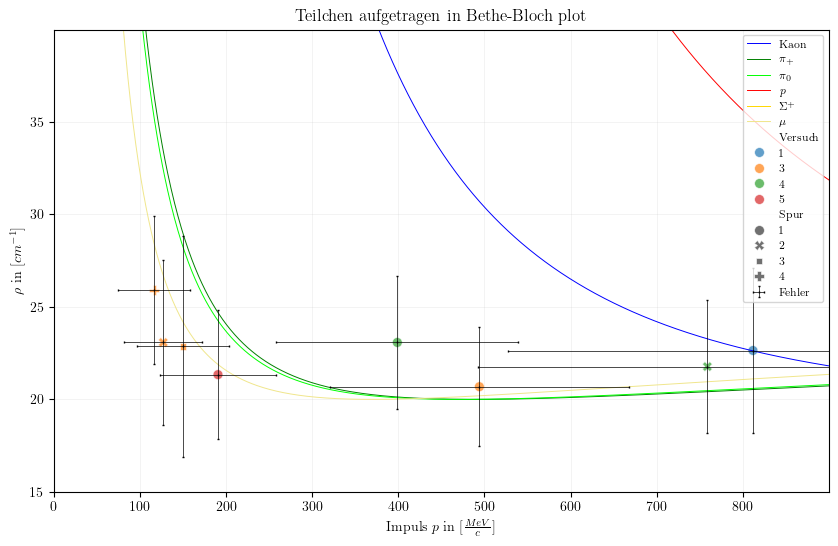

In [143]:
x_values = []
y_values = []
colors = []
labels = []
for (index1, index2), (x, y) in calc_list1:
    x_values.append(x)
    y_values.append(y)
    colors.append((index1, index2))
    labels.append(f'Versuch {index1}, Spur {index2}')

data = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'Versuch': [color[0] for color in colors],
    'Spur': [color[1] for color in colors],
    'label': labels
})




p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

sns.scatterplot(x='x', y='y', hue='Versuch', style='Spur', palette='tab10', data=data, s=50, alpha=0.7, ax=ax)


xvalue = [val[0] for _, val in calc_list1]
yvalue = [val[1] for _, val in calc_list1]
xerror = [error[0] for _, error in errors]
yerror = [error[1] for _, error in errors]
ax.errorbar(xvalue, yvalue, xerr=xerror, yerr=yerror, fmt='|', color='black', 
            label=f'Fehler', markersize=1, elinewidth=0.5, capsize=1, capthick=1)

ylimmin = 15
ylimmax = 40
xlimmin = 0
xlimmax = 900
ax.set_title('Teilchen aufgetragen in Bethe-Bloch plot')
ax.set_ylim([ylimmin, ylimmax]) 
ax.set_xlim([xlimmin,xlimmax])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(xlimmin, xlimmax, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(ylimmin, ylimmax, 5)) 
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Teilchenidentifikation.pdf")
plt.show()

In [144]:
total_df

charge  r_gem  delta_r_gem      r_real  delta_r_real  \
Versuch Teilchenspur                                                        
1       1                 -  230.0          7.5  132.101435      4.311364   
2       1                 -   65.0          2.5   37.333014      1.436774   
        2                 +   80.0          2.5   45.948325      1.437231   
        3                 -   90.0          2.5   51.691866      1.437588   
3       1                 -  140.0          5.0   80.409569      2.873831   
        2                 -   36.0          2.5   20.676746      1.436158   
        3                 +   42.5          2.5   24.410048      1.436265   
        4                 +   33.0          2.5   18.953684      1.436114   
4       1                 +  113.0          5.0   64.902010      2.873113   
        2                 -  215.0          7.5  123.486124      4.310896   
5       1                 -   54.0          2.5   31.015120      1.436499   

                      angle  delta_angle    momentum  delta_momentum  \
Versuch Teilchenspur                                                   
1       1               0.0          0.0  811.882212      284.636370   
2       1              25.0         10.0  229.444973       80.576713   
        2               9.0         10.0  282.393813       98.969005   
        3              14.0         10.0  317.693039      111.247196   
3       1             -25.0         10.0  494.189172      173.406403   
        2             -22.0         10.0  127.077216       45.227945   
        3              42.0         10.0  150.021713       53.106205   
        4              57.0         10.0  116.487448       41.608692   
4       1             -30.5         10.0  398.881261      140.351044   
        2              56.0         10.0  758.933372      266.239272   
5       1             -58.0         10.0  190.615824       67.120632   

                            rho delta_rho  
Versuch Teilchenspur                       
1       1             22.634122  4.444708  
2       1                   NaN       NaN  
        2                   NaN       NaN  
        3                   NaN       NaN  
3       1               20.6754   3.21766  
        2             23.069394  4.474749  
        3             22.851758  5.983187  
        4             25.898659  4.010582  
4       1             23.069394  3.604232  
        2             21.763579  3.604232  
5       1             21.328307  3.482292

In [145]:
total_df.loc[(4,2),'momentum']

rho_kaon_comp = bubbledensity(calibration_value, mass_kaon, total_df.loc[(4,2),'momentum'])
rho_pion_comp = bubbledensity(calibration_value, mass_pion_charged, total_df.loc[(4,2),'momentum'])
rho_4_comp = total_df.loc[(4,2), 'rho']
ic(rho_kaon_comp - rho_4_comp)
ic(rho_4_comp - rho_pion_comp)

ic| rho_kaon_comp - rho_4_comp: 1.502139504040425
ic| rho_4_comp - rho_pion_comp: 1.359578834901665


1.359578834901665

Versuch 1 ist die Abmessung vom Eingangsstrahl und liegt wie erwartet auf der Kaonkurve. \
Versuch 3: \
Eingangsspur teilt sich auf in Spur 1 und 4, dann in Spur 2 und 3.
* Spur 1 ist negativ und hat einen hohen Impuls.
* Spur 2 ist negativ und liegt auf den Pionkurven. Negatives pion würde Sinn ergeben.
* Spur 3 ist positiv und liegt ebenfalls auf den Pionkurven $\to$ positives Pion
* Spur 4 ist positiv und liegt auf den Pionkurven. Positives Pion \
Problem: alle sind Pionen!
<br>

Versuch 4: \
Eingangsspur teilt sich auf in Spur 1 und 2.
* Spur 1 ist positiv und kann entweder ein positives pion oder ein proton sein. Da die Spur im y-Wert weit weg von der Protonkurve liegt, handelt es sich vermutlich um ein pion.
* Spur 2 ist negativ und könnte entweder kaon oder pion sein. Von den y-Werten her liegt spur 2 der pionkurve näher
<br>

Versuch 5: \
Spur 1 ist das negative pion. 

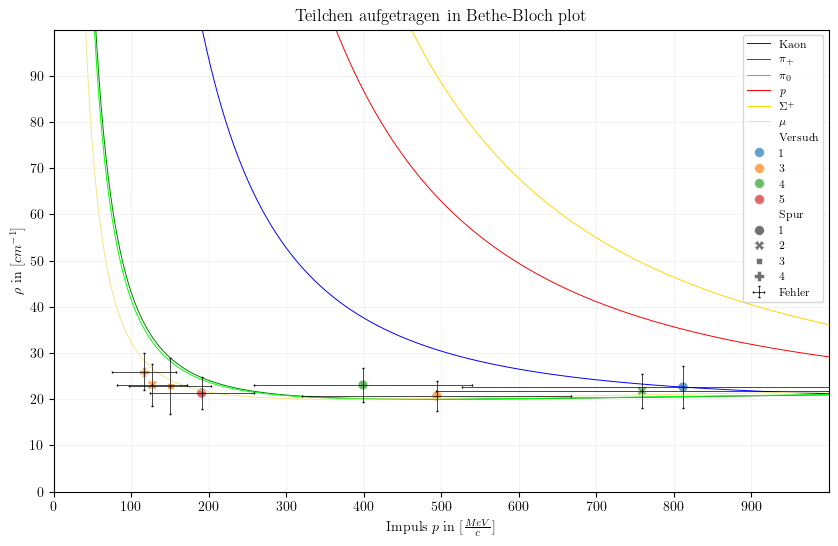

In [146]:
p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

sns.scatterplot(x='x', y='y', hue='Versuch', style='Spur', palette='tab10', data=data, s=50, alpha=0.7, ax=ax)


xvalue = [val[0] for _, val in calc_list1]
yvalue = [val[1] for _, val in calc_list1]
xerror = [error[0] for _, error in errors]
yerror = [error[1] for _, error in errors]
ax.errorbar(xvalue, yvalue, xerr=xerror, yerr=yerror, fmt='|', color='black', 
            label=f'Fehler', markersize=1, elinewidth=0.5, capsize=1, capthick=1)

ylimmin = 0
ylimmax = 100
xlimmin = 0
xlimmax = 1000
ax.set_title('Teilchen aufgetragen in Bethe-Bloch plot')
ax.set_ylim([ylimmin, ylimmax]) 
ax.set_xlim([xlimmin,xlimmax])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(xlimmin, xlimmax, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(ylimmin, ylimmax, 10)) 
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Teilchenidentifikation_large.pdf")
plt.show()

## Tabellen für Latex

In [147]:
# Gesamttabelle mit besseren Bezeichnungen (aufgrund der column Namen nicht für Datenanalyse geeignet)
total_df2 = total_df.copy()
total_df2.columns = ['Ladung',
                    f'r$_{{gem}} [cm]$', f'$\\Delta r_{{gem}} [cm]$', 
                    f'$r_{{real}} [cm]$', f'$\\Delta r_{{real}} [cm]$', 
                    f'Winkel $\\phi [\u00B0]$', f'$\\Delta \\phi [\u00B0]$', 
                    f'$p [\\frac{{MeV}}{{c}}]$', f'$\\Delta p [\\frac{{MeV}}{{c}}]$', 
                    f'$\\rho_{{Bl}}$', f'$\\Delta \\rho_{{Bl}}$']

latex_table = total_df2.to_latex(
    index=True, 
    escape=False,
    caption="Parameterwerte für die Impulsberechnung mittels Kinematik. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:momentumkinematic", 
    position="H",  
    column_format="llrrrrrrrrrrr", 
    float_format="{:0.2f}".format)

print(latex_table)
total_df2

\begin{table}[H]
\caption{Parameterwerte für die Impulsberechnung mittels Kinematik. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100}
\label{tab:momentumkinematic}
\begin{tabular}{llrrrrrrrrrrr}
\toprule
 &  & Ladung & r$_{gem} [cm]$ & $\Delta r_{gem} [cm]$ & $r_{real} [cm]$ & $\Delta r_{real} [cm]$ & Winkel $\phi [°]$ & $\Delta \phi [°]$ & $p [\frac{MeV}{c}]$ & $\Delta p [\frac{MeV}{c}]$ & $\rho_{Bl}$ & $\Delta \rho_{Bl}$ \\
Versuch & Teilchenspur &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 1 & - & 230.00 & 7.50 & 132.10 & 4.31 & 0.00 & 0.00 & 811.88 & 284.64 & 22.63 & 4.44 \\
\cline{1-13}
\multirow[t]{3}{*}{2} & 1 & - & 65.00 & 2.50 & 37.33 & 1.44 & 25.00 & 10.00 & 229.44 & 80.58 & NaN & NaN \\
 & 2 & + & 80.00 & 2.50 & 45.95 & 1.44 & 9.00 & 10.00 & 282.39 & 98.97 & NaN & NaN \\
 & 3 & - & 90.00 & 2.50 & 51.69 & 1.44 & 14.00 & 10.00 & 317.69 & 111.25 & NaN & NaN \\
\cline{1-13}
\multirow[t]{4}{*}{3} & 1 & - & 140.00 & 5.00 & 80.41 & 2.87 & -25.00 & 1

Ladung  r$_{gem} [cm]$  $\Delta r_{gem} [cm]$  \
Versuch Teilchenspur                                                 
1       1                 -           230.0                    7.5   
2       1                 -            65.0                    2.5   
        2                 +            80.0                    2.5   
        3                 -            90.0                    2.5   
3       1                 -           140.0                    5.0   
        2                 -            36.0                    2.5   
        3                 +            42.5                    2.5   
        4                 +            33.0                    2.5   
4       1                 +           113.0                    5.0   
        2                 -           215.0                    7.5   
5       1                 -            54.0                    2.5   

                      $r_{real} [cm]$  $\Delta r_{real} [cm]$  \
Versuch Teilchenspur                                            
1       1                  132.101435                4.311364   
2       1                   37.333014                1.436774   
        2                   45.948325                1.437231   
        3                   51.691866                1.437588   
3       1                   80.409569                2.873831   
        2                   20.676746                1.436158   
        3                   24.410048                1.436265   
        4                   18.953684                1.436114   
4       1                   64.902010                2.873113   
        2                  123.486124                4.310896   
5       1                   31.015120                1.436499   

                      Winkel $\phi [°]$  $\Delta \phi [°]$  \
Versuch Teilchenspur                                         
1       1                           0.0                0.0   
2       1                          25.0               10.0   
        2                           9.0               10.0   
        3                          14.0               10.0   
3       1                         -25.0               10.0   
        2                         -22.0               10.0   
        3                          42.0               10.0   
        4                          57.0               10.0   
4       1                         -30.5               10.0   
        2                          56.0               10.0   
5       1                         -58.0               10.0   

                      $p [\frac{MeV}{c}]$  $\Delta p [\frac{MeV}{c}]$  \
Versuch Teilchenspur                                                    
1       1                      811.882212                  284.636370   
2       1                      229.444973                   80.576713   
        2                      282.393813                   98.969005   
        3                      317.693039                  111.247196   
3       1                      494.189172                  173.406403   
        2                      127.077216                   45.227945   
        3                      150.021713                   53.106205   
        4                      116.487448                   41.608692   
4       1                      398.881261                  140.351044   
        2                      758.933372                  266.239272   
5       1                      190.615824                   67.120632   

                     $\rho_{Bl}$ $\Delta \rho_{Bl}$  
Versuch Teilchenspur                                 
1       1              22.634122           4.444708  
2       1                    NaN                NaN  
        2                    NaN                NaN  
        3                    NaN                NaN  
3       1                20.6754            3.21766  
        2              23.069394           4.474749  
        3              22.851758           5.983187  
        4            

In [148]:
# Dataframe aufgetrennt wegen hoher Breite
mid = 7
df_total_1 = total_df2.iloc[:,:mid]
df_total_2 = total_df2.iloc[:,mid:]

In [149]:
# erste Hälfte
df_total_1
latex_table = df_total_1.to_latex(
    index=True, 
    escape=False,
    caption="Gemessene Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:measuredvalues", 
    position="H",  
    column_format="llrrrrrrr", 
    float_format="{:0.2f}".format)
print(latex_table)

\begin{table}[H]
\caption{Gemessene Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100}
\label{tab:measuredvalues}
\begin{tabular}{llrrrrrrr}
\toprule
 &  & Ladung & r$_{gem} [cm]$ & $\Delta r_{gem} [cm]$ & $r_{real} [cm]$ & $\Delta r_{real} [cm]$ & Winkel $\phi [°]$ & $\Delta \phi [°]$ \\
Versuch & Teilchenspur &  &  &  &  &  &  &  \\
\midrule
1 & 1 & - & 230.00 & 7.50 & 132.10 & 4.31 & 0.00 & 0.00 \\
\cline{1-9}
\multirow[t]{3}{*}{2} & 1 & - & 65.00 & 2.50 & 37.33 & 1.44 & 25.00 & 10.00 \\
 & 2 & + & 80.00 & 2.50 & 45.95 & 1.44 & 9.00 & 10.00 \\
 & 3 & - & 90.00 & 2.50 & 51.69 & 1.44 & 14.00 & 10.00 \\
\cline{1-9}
\multirow[t]{4}{*}{3} & 1 & - & 140.00 & 5.00 & 80.41 & 2.87 & -25.00 & 10.00 \\
 & 2 & - & 36.00 & 2.50 & 20.68 & 1.44 & -22.00 & 10.00 \\
 & 3 & + & 42.50 & 2.50 & 24.41 & 1.44 & 42.00 & 10.00 \\
 & 4 & + & 33.00 & 2.50 & 18.95 & 1.44 & 57.00 & 10.00 \\
\cline{1-9}
\multirow[t]{2}{*}{4} & 1 & + & 113.00 & 5.00 & 64.90 & 2.87 & -30

In [150]:
# zweite Hälfte
df_total_2
latex_table = df_total_2.to_latex(
    index=True, 
    escape=False,
    caption="Berechnete Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:calculatedvalues", 
    position="H",  
    column_format="llrrrrrrr", 
    float_format="{:0.2f}".format)
print(latex_table)

\begin{table}[H]
\caption{Berechnete Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100}
\label{tab:calculatedvalues}
\begin{tabular}{llrrrrrrr}
\toprule
 &  & $p [\frac{MeV}{c}]$ & $\Delta p [\frac{MeV}{c}]$ & $\rho_{Bl}$ & $\Delta \rho_{Bl}$ \\
Versuch & Teilchenspur &  &  &  &  \\
\midrule
1 & 1 & 811.88 & 284.64 & 22.63 & 4.44 \\
\cline{1-6}
\multirow[t]{3}{*}{2} & 1 & 229.44 & 80.58 & NaN & NaN \\
 & 2 & 282.39 & 98.97 & NaN & NaN \\
 & 3 & 317.69 & 111.25 & NaN & NaN \\
\cline{1-6}
\multirow[t]{4}{*}{3} & 1 & 494.19 & 173.41 & 20.68 & 3.22 \\
 & 2 & 127.08 & 45.23 & 23.07 & 4.47 \\
 & 3 & 150.02 & 53.11 & 22.85 & 5.98 \\
 & 4 & 116.49 & 41.61 & 25.90 & 4.01 \\
\cline{1-6}
\multirow[t]{2}{*}{4} & 1 & 398.88 & 140.35 & 23.07 & 3.60 \\
 & 2 & 758.93 & 266.24 & 21.76 & 3.60 \\
\cline{1-6}
5 & 1 & 190.62 & 67.12 & 21.33 & 3.48 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}



In [151]:
momentum_total_df = pd.concat([momentum_x_total_df, momentum_y_total_df], axis=1)
momentum_total_df.columns = [f'p$_{{x}}[\\frac{{MeV}}{{c}}]$', f'$\\Delta p_{{x}}[\\frac{{MeV}}{{c}}]$', f'p$_{{y}}[\\frac{{MeV}}{{c}}]$', f'$\\Delta p_{{y}}[\\frac{{MeV}}{{c}}]$']
momentum_total_df.index.name = 'Versuch'
momentum_total_df

latex_table = momentum_total_df.to_latex(
    index=True, 
    escape=False,
    caption="Restimpulse der Ausgangsseite",
    label="tab:momentumrest", 
    position="H",  
    column_format="lrrrr", 
    float_format="{:0.2f}".format)
print(latex_table)

\begin{table}[H]
\caption{Restimpulse der Ausgangsseite}
\label{tab:momentumrest}
\begin{tabular}{lrrrr}
\toprule
 & p$_{x}[\frac{MeV}{c}]$ & $\Delta p_{x}[\frac{MeV}{c}]$ & p$_{y}[\frac{MeV}{c}]$ & $\Delta p_{y}[\frac{MeV}{c}]$ \\
Versuch &  &  &  &  \\
\midrule
1 & 811.88 & 284.64 & 0.00 & 0.00 \\
2 & 795.12 & 164.52 & 218.00 & 93.30 \\
3 & 740.64 & 174.71 & -58.38 & 123.18 \\
4 & 768.08 & 223.82 & 426.74 & 250.75 \\
5 & 101.01 & 45.40 & -161.65 & 59.59 \\
\bottomrule
\end{tabular}
\end{table}



In [152]:
energy_latex_df = energy_df.copy()
energy_latex_df.columns = ['Ladung', f'$E_{{K^{{-}}}}$', f'$\\Delta E_{{K^{{-}}}}$', f'$E_{{\\pi^{{±}}}}$', f'$\\Delta E_{{\\pi^{{±}}}}$', f'$E_{{p^{{+}}}}$',f'$\\Delta E_{{p^{{+}}}}$']
energy_latex_df

latex_table = energy_latex_df.to_latex(
    index=True, 
    escape=False,
    caption="Energie der vermuteten Ausgangsteilchen",
    label="tab:energyhypothesis", 
    position="H",  
    column_format="llrrrrrrr", 
    float_format="{:0.2f}".format)
print(latex_table)

\begin{table}[H]
\caption{Energie der vermuteten Ausgangsteilchen}
\label{tab:energyhypothesis}
\begin{tabular}{llrrrrrrr}
\toprule
 &  & Ladung & $E_{K^{-}}$ & $\Delta E_{K^{-}}$ & $E_{\pi^{±}}$ & $\Delta E_{\pi^{±}}$ & $E_{p^{+}}$ & $\Delta E_{p^{+}}$ \\
Versuch & Teilchenspur &  &  &  &  &  &  &  \\
\midrule
1 & 1 & - & 950.21 & 243.20 & 823.79 & 280.52 & NaN & NaN \\
\cline{1-9}
\multirow[t]{3}{*}{2} & 1 & - & 544.41 & 33.96 & 268.56 & 68.84 & NaN & NaN \\
 & 2 & + & NaN & NaN & 315.00 & 88.72 & 979.85 & 28.52 \\
 & 3 & - & 587.08 & 60.20 & 347.00 & 101.85 & NaN & NaN \\
\cline{1-9}
\multirow[t]{4}{*}{3} & 1 & - & 698.54 & 122.68 & 513.52 & 166.88 & NaN & NaN \\
 & 2 & - & 509.79 & 11.27 & 188.75 & 30.45 & NaN & NaN \\
 & 3 & + & NaN & NaN & 204.91 & 38.88 & 950.19 & 8.38 \\
 & 4 & + & NaN & NaN & 181.79 & 26.66 & 945.47 & 5.13 \\
\cline{1-9}
\multirow[t]{2}{*}{4} & 1 & + & NaN & NaN & 422.59 & 132.48 & 1019.54 & 54.91 \\
 & 2 & - & 905.38 & 223.17 & 771.66 & 261.85 & NaN & NaN \\
